# **Multiclass Logistic Regression**

In this notebook we discuss some basic aspects of the multiclass logistic regression and illustrate our `LogisticRegressior` module.

## 1 - Set up

In [1]:
import numpy as np #to handle data
import matplotlib.pyplot as plt #visualisation tools
import seaborn as sns
from ucimlrepo import fetch_ucirepo #load repo with the iris dataset

from logistic_regression import LogisticRegressor #our linear regression module

## 2 - Basics of logistic regression

### 2.1 - The model
**Conditional probabilities:** We consider a random variable $\Upsilon$ and a set of independent events $\omega = \{\Upsilon_1, \dots, \Upsilon_n\}$, where $\Upsilon_i \in \{\textrm{class}_1, \dots, \textrm{class}_K\}$. We *assume* that to the sequency of events corresponds another sequency of predictors values $\chi = \{\vec{x}_1, \dots, \vec{x}_n\}$, where $\vec{x}_i \in \mathbb{R}^p$ for $i = 1, \dots, n$. Furthermore, the conditional probability of the random variable $\Upsilon$ to assume a given class is given by the softmax function
$$
P(\Upsilon = \textrm{class}_k|b_1, \dots, b_K; \vec{x}_i) = \frac{\textrm{e}^{b_{0, k} + \vec{x}_i \cdot \vec{b}_k}}{Z(b_1, \dots, b_K; \vec{x}_i)},
$$
where $b_{0, k}$ is the bias term, $b_k = (b_{0, k}, \vec{b}_k)$ and $Z_i$ a normalisation factor across the classes:
$$
Z(b_1, \dots, b_K; \vec{x}_i) = \sum_{r = 1}^K\textrm{e}^{b_{0, r} + \vec{x}_i \cdot \vec{b}_r}.
$$

The softmax function has a symmetry under the changing the coefficients $b_k$ by a constant $c_i = (c_0, \vec{c})$ due to the normalisation factor. Indeed,
$$
P(\Upsilon = \textrm{class}_k|b_1, \dots, b_k + c, \dots, b_K; \vec{x}_i) = \frac{\textrm{e}^{b_{0, k} + c_0  + \vec{x}_i \cdot \vec{b}_k + \vec{x}_i \cdot \vec{c}}}{\sum_{r = 1}^K\textrm{e}^{b_{0, r} + c_0  + \vec{x}_i \cdot \vec{b}_r + \vec{x}_i \cdot \vec{c}}} = P(\Upsilon = \textrm{class}_k|b_1, \dots, b_K; \vec{x}_i).
$$
In the statistics and machine learning literature, this model is said to be non-identifiable unless this freedom is fixed by a suitable choice of the coefficients $b_k$. A popular choice to set the coefficients of one particular class, say $\textrm{class}_K$, to zero. Here we will take
$$
b_K = (0, \vec{0}),
$$
which reduces the conditional probability to
$$
P(\Upsilon = \textrm{class}_k|b_1, \dots, b_{K-1}; \vec{x}_i) = \frac{\textrm{e}^{b_{0, k} + \vec{x}_i \cdot \vec{b}_k}}{1 + \sum_{r = 1}^{K-1}\textrm{e}^{b_{0, r} + \vec{x}_i \cdot \vec{b}_r}}.
$$

It is also interesting to notice that although the relationship between the probabilities in logistic regression and the predictors is non-linear, the log-odds (a.k.a. logit) function 
$$
\ln\left(\frac{P(\Upsilon = \textrm{class}_k|b_1, \dots, b_{K-1}; \vec{x}_i)}{1 - \sum_{r = 1}^{K-1}P(\Upsilon = \textrm{class}_r|b_1, \dots, b_{K-1}; \vec{x}_i)}\right) = b_{0, k} + \vec{x}_i \cdot \vec{b}_k
$$
is linear in the predictors.

**Maximum likelyhood method:** Next, we consider the set of observations $O = \{y_1, \dots, y_n\}$ of the events in $\omega$. We want to use the observations $O$ to estimate the coefficients $b_1, \dots, b_K$ by $\hat{b}_1, \dots, \hat{b}_K$ in such a way that the likelyhood function $L(b_1, \dots, b_{K-1}|O, \chi)$ is maximum. To apply this method, it is convenient to take the logarithm of $L$ and consider the log-likelyhood function
$$
\ell(b_1, \dots, b_{K-1}|O, \chi) = \sum_{i = 1}^n\sum_{k = 1}^Kg_k(y_i)\ln P(\Upsilon = \textrm{class}_k|b_1, \dots, b_{K-1}; \vec{x}_i),
$$
where the function $g$ is defined as
$$
g_k(y) = \left\{
\begin{array}{ll}
1, & \textrm{if } y = \textrm{class}_k \\
0, & \textrm{otherwise}. \\
\end{array}
\right.
$$

It is convenient to define the following matrix notation for the observations of the $\Upsilon$ variable, the predictors $\vec{x}_1, \dots, \vec{x}_p$ and coefficients $b_1, \dots, b_{K}$:
$$
Y = 
\begin{bmatrix}
g_1(y_1) & \dots & g_K(y_1)\\
\vdots & \ddots & \vdots\\
g_1(y_n) & \dots & g_K(y_n)
\end{bmatrix}_{n\times K}, \;\;\;\;\;
X =
\begin{bmatrix}
1 & x_{1,\ 1} & \dots & x_{1,\ p}\\
\vdots & \vdots & \ddots & \vdots\\
1 & x_{n,\ 1} & \dots & x_{n,\ p}
\end{bmatrix}_{n\times(p+1)},
$$
$$
B = 
\begin{bmatrix}
b_{0, \ 1} & \dots & b_{0, \ K - 1} & 0\\
\vdots & \vdots & \vdots & \vdots\\
b_{p, \ 1} & \dots & b_{p, \ K-1} & 0
\end{bmatrix}_{(p + 1)\times K}, 
\;\;\;\;\; \textrm{and} \;\;\;\;\;
\Pi(B, X) =
\begin{bmatrix}
P(\Upsilon = \textrm{class}_1|b_1, \dots, b_{K-1}; \vec{x}_1) & \dots & P(\Upsilon = \textrm{class}_K|b_1, \dots, b_{K-1}; \vec{x}_1)\\
\vdots & \ddots & \vdots\\
P(\Upsilon = \textrm{class}_1|b_1, \dots, b_{K-1}; \vec{x}_n) & \dots & P(\Upsilon = \textrm{class}_K|b_1, \dots, b_{K-1}; \vec{x}_n)\\
\end{bmatrix}_{n\times K}.
$$
We note that the matrix $Y$ is simply the "one-hot" encoding of the sample vector $y = (y_1, \dots, y_n)$. In this notation the log-likelyhood function is given by
$$
\ell(B| Y, X) = \sum_{i = 1}^n\sum_{k = 1}^K Y_{ik}\ln\Pi_{ik} = \textrm{tr}[Y^\textrm{T}\ln\Pi(B, X)], 
$$
and we stress that the $\ln\Pi$ notation here is understood as taking the logarithm of the matrix $\Pi$ component-wise.

To find the maximum of $\ell$, we first compute
$$
\frac{\partial \Pi_{ik}}{\partial B_{rs}} = X_{ir}(\delta_{ks} - \Pi_{is})\Pi_{ik}.
$$
Thus,
$$
\frac{\partial \ell}{\partial B_{rs}} = \sum_{i = 1}^n\sum_{k = 1}^K Y_{ik}X_{ir}(\delta_{ks} - \Pi_{is}).
$$
Since $\sum_{k = 1}^K Y_{ik} = 1$, we conclude that the maximum likelyhood estimator (MLE) $\hat{B}$ for the regression coefficients matrix $B$ satisfies
$$
0 = X^\textrm{T}[Y - \Pi(\hat{B}, X)],
$$
which is a $(p+1)\times K$ matrix equation. We notice that the equation above has a structure that resembles the one of the equation for the coefficients estimators obtained using the method of least squares in the linear regression model. In the logistic regression model, however, the equation is no longer linear in the coefficients estimators and we need a numerical method to solve it.

### 2.2 - The Newton-Raphson (NR) method

The NR method is designed to find approximate roots of a given function. Consider a function $y = f(x)$. The idea is to locally approximate the function at a given point $x_0$ by using the value of the tangent to the function at $x_0$. The root of the function is then approximated by the point where the tangent intersects the $x$-axis.

In the NR method, we start by selecting a initial point $\hat{B}_0$ and considering a small correction $\Delta B$. The expansion of the log-likelyhood function $\ell$ around $\hat{B}_0$ is then
$$
\ell(\hat{B}_0 + \Delta B|Y, X) = \ell(\hat{B}_0|Y, X) + \sum_{rs}\frac{\partial}{\partial B_{rs}} \ell(\hat{B}_0|Y, X)\Delta B_{rs} + \frac{1}{2}\sum_{rs, tu}\frac{\partial^2}{\partial B_{tu}\partial B_{rs}} \ell(\hat{B}_0|Y, X)\Delta B_{rs}\Delta B_{tu} + \dots,
$$
with $r, t = 1, \dots, p+1$ and $s, u = 1, \dots, K$. Note that above we have simplified the notation for the summation. The second partial derivative of $\ell$ with respect to the regression coefficients is
$$
\frac{\partial^2}{\partial B_{tu}\partial B_{rs}} \ell = -\sum_{i = 1}^n X^\textrm{T}_{ri}[S_{su}(B, X)]_{ii}X_{it},
$$
where
$$
[S_{su}(B, X)]_{ii} = [\delta_{su} - \Pi_{iu}(B, X)]\Pi_{is}(B, X).
$$
Hence we have a Hessian matrix for $\ell$ that is made out of $(p + 1)\times (p + 1)$ matrices
$$
H_{su}(B| X) = - X^\textrm{T}S_{su}(B, X)X,
$$
which are symmetric under $s\leftrightarrow u$.

To implement the NR method for the multiclass logistic model in terms of simple matrix equations, it is convenient to represent the coefficient matrix $B$ as the vector $[B]$ by stacking its columns as a $(p + 1)K$-column vector, i.e.
$$
[B] = 
\begin{bmatrix}
b_{0,\ 1} & \dots & b_{p,\ 1} & \dots & b_{0,\ K} & \dots & b_{p,\ K}
\end{bmatrix}^\textrm{T}
$$
The Hessian matrix is then represented as a $(p+1)K\times (p+1)K$ symmetric block matrix in the form
$$
H(B| X) = 
\begin{bmatrix}
H_{1,\ 1}(B| X) & \dots & H_{1,\ K}(B| X)\\ 
\vdots & \ddots & \vdots \\
H_{K,\ 1}(B| X) & \dots & H_{K,\ K}(B| X)
\end{bmatrix}_{(p+1)K\times(p+1)K}.
$$

Using the expansion above for the log-likelyhood function and the new representation for the coefficient matrix, $[B]$, and the Hessian, $H$, we have that its maximum happens when
$$
0 = \frac{\partial}{\partial \Delta [B]_i}\ell([\hat{B}_0] + \Delta [B]| Y, X) = X^\textrm{T}[Y - \Pi(\hat{B}_0, X)] + H(\hat{B}_0| X)\Delta[B].
$$
Hence, the correction to the our first guess is 
$$
\Delta[B] = - [H(\hat{B}_0| X)]^{-1}[G](\hat{B}_0|Y, X),
$$
where $G(B|Y, X) = X^\textrm{T}[Y - \Pi(B, X)]$ is the gradient of $\ell$ and $[G]$ is its representation as a $(p+1)K$-column vector.

The method converges quadratically, as long as
1. the classes are not perfectly separated from one another, so $\ell$ has an unique and finite maximum,
2. the predictors are linear independent (i.e. that $X$ is of full rank), so the inverse of the Hessian matrix exists
3. and the $\frac{1}{n}\sum_{i = 1}^n(XX^\textrm{T})_{ii} < \infty$ (i.e. the sum of the norms of the predictors in $\mathbb{R}^{p+1}$ is finite), so the Hessian is bounded. 

The conditions 1-3 guarantee that the log-likelyhood function has a well-defined maximum and that the Hessian matrix is invertible.

## 3 - Statistical analysis of the coefficients

### 3.1 - Estimation interval

We would like to determine how accurate are our coefficient estimate $\hat{B}$ as an approximation for the true value $B$. We notice that $\hat{B}$ is a random variable obtained as a (non-linear) combination of the events $\omega$ of the random variable $\Upsilon$ defined as a maximum likelyhood estimator. Under the conditions 1-3, the log-likelyhood function $\ell$ is a concave function with one, and just one, MLE $\hat{B}$. Moreover, it is possible to show that as $n\to \infty$, the coefficients $\hat{B}$ exist in that limit and correspond to the true value of $B$ of the coefficients.

Hence, let us assume that $n \gg 1$, i.e. we have a high enough number of samples. In this case, the MLE $\hat{B}$ is close to the true value $B$ and we can approximate its equation around that true value by a linear equation. The expansion around $B$ is similar to the the one performed above for the equations defining the NR method, and thus 
$$
[\hat{B}] - [B] = -[H(B| X)]^{-1}[G](B|Y, X).
$$

Since $Y_{ik} \in \{0,1\}$ and $Y_{ik} \sim \textrm{Bernoulli}(\Pi_{ik})$, we have the following expectation values
$$
\textrm{E}(Y_{ik}) = \Pi_{ik} \;\;\;\;\;\textrm{and}\;\;\;\;\; \textrm{E}(Y_{ik}Y_{jk'}) = \Pi_{ik}(\delta_{kk'} - \Pi_{ik'})\delta_{ij} + \Pi_{ik}\Pi_{jk'}
$$
Then, the expectation of the MLE is
$$
\textrm{E}([\hat{B}] - [B]) = -[H(B|X)]^{-1}[X^\textrm{T}(\textrm{E}(Y) - \Pi(B, X))] = 0
$$
and
$$
\textrm{E}(([\hat{B}] - [B])([\hat{B}] - [B])^\textrm{T}) = [H(B| X)]^{-1}\textrm{E}([X^\textrm{T}(Y - \Pi(B, X))][X^\textrm{T}(Y - \Pi(B, X))][H(B| X)]^{-1} = [H(B| X)]^{-1}.
$$

Moreover, in this large $n$ regime, the MLE becomes a linear combination of random variables and thus follows in good approximation 
$$
[\hat{B}] \sim \textrm{Normal}\left([B], \frac{1}{n} \Sigma(B| X)\right),
$$
where $\Sigma(B| X) = [H(B| X)]^{-1}$ is the $(p+1)K\times (p+1)K$ covariance matrix of $[\hat{B}]$. Finally we define $Z$-statistics for the MLE $[\hat{B}]_i$ as
$$
Z_i = \frac{[\hat{B}]_i}{\sqrt{\frac{1}{n}\Sigma_{ii}(\hat{B}|X)}}.
$$
Note that what appears in the denominator of the $Z$-statistics is the estimator for the covariance matrix of $\hat{B}$. A large absolute value of $Z_i$ is evidence againts the null hypothesis $[\hat{B}]_i = 0$. 

### 3.2 - Hypothesis testing

We would like to test the hypothesis of whether $\hat{B}$ are null or not for a given predictor, up to a certain significance level. This assess the effect of adding that corresponding predictor to the model. For the $i$-th predictor, the null and alternative hypothesis are
\begin{split}
&\textrm{H}_0\ \textrm{:}\; \hat{B}_{i,\ 1} = \dots = \hat{B}_{i,\ K-1} = 0,\\
&\textrm{H}_\textrm{a}\ \textrm{: at leats one}\; \hat{B}_{ik} \neq 0.
\end{split}

Let us define the $(K-1)$-column vector $\hat{\beta}_i = (\hat{B}_{i,\ 1}, \dots, \hat{B}_{i,\ K-1})^\textrm{T} = ([\hat{B}]_{i}, \dots, [\hat{B}]_{(k-1)(p+1) + i}, \dots, [\hat{B}]_{(K-1)(p+1) + i})^\textrm{T}$. The relevant statistics for the joint test on $\hat{\beta}_i$ is
$$
W_i = \hat{\beta}_i^\textrm{T}\Sigma_i^{-1}\hat{\beta}_i,
$$
the Wald statistics, where $\Sigma_i$ is the $(K-1)\times(K-1)$ covariance submatrix. It is defined from the full covariance matrix $\Sigma$ as
$$
\Sigma_i = \frac{1}{n}
\begin{bmatrix}
\Sigma_{i,\ i} & \dots & \Sigma_{i,\ (k-1)(p+1) + i} & \dots & \Sigma_{i,\ (K-1)(p+1) + i}\\
\vdots & \ddots & \vdots & \ddots & \vdots\\
\Sigma_{(k' - 1)(p+1) + i,\ i} & \dots & \Sigma_{(k' - 1)(p+1) + i,\ (k-1)(p+1) + i} & \dots & \Sigma_{(k' - 1)(p+1) + i,\ (K-1)(p+1) + i}\\
\vdots & \ddots & \vdots & \ddots & \vdots\\
\Sigma_{(K - 1)(p + 1) + i,\ i} & \dots & \Sigma_{(K - 1)(p + 1) + i,\ (k-1)(p+1) + i} & \dots & \Sigma_{(K - 1)(p + 1) + i,\ (K-1)(p+1) + i}
\end{bmatrix}
$$

Under $\textrm{H}_0$, the Wald statistics follows a $\chi^2$ distribution with $K-1$ degrees of freedom, i.e. $W_i \sim \chi^2(K-1)$. The $p$-value for the $i$-th predictor in this case is given by
$$
p_i = 1 - F_{\chi^2(K-1)}(W_i),
$$
where 
$$
F_{\chi^2(K-1)}(x) = \int_0^x dx' \chi^2(K-1, x'),
$$
the cummulative distribution function for the $\chi^2$ distribution.

## 4 - The `LogisticRegressor` module

To test and demonstrate the features of the `LogisticRegressor` module, we consider the Iris Dataset.

### 4.1 - Brief exploratory data analysis

In [2]:
# load iris dataset 
iris = fetch_ucirepo(id=53)

iris_df = iris.data.original

Each sample in the Iris Dataset represents an iris plant. It contains 3 species of the plant (setosa, vericolor and virginica) with 50 instances. The features of each plant are the length and width in cm of the petal and sepal of the plant's flowers.

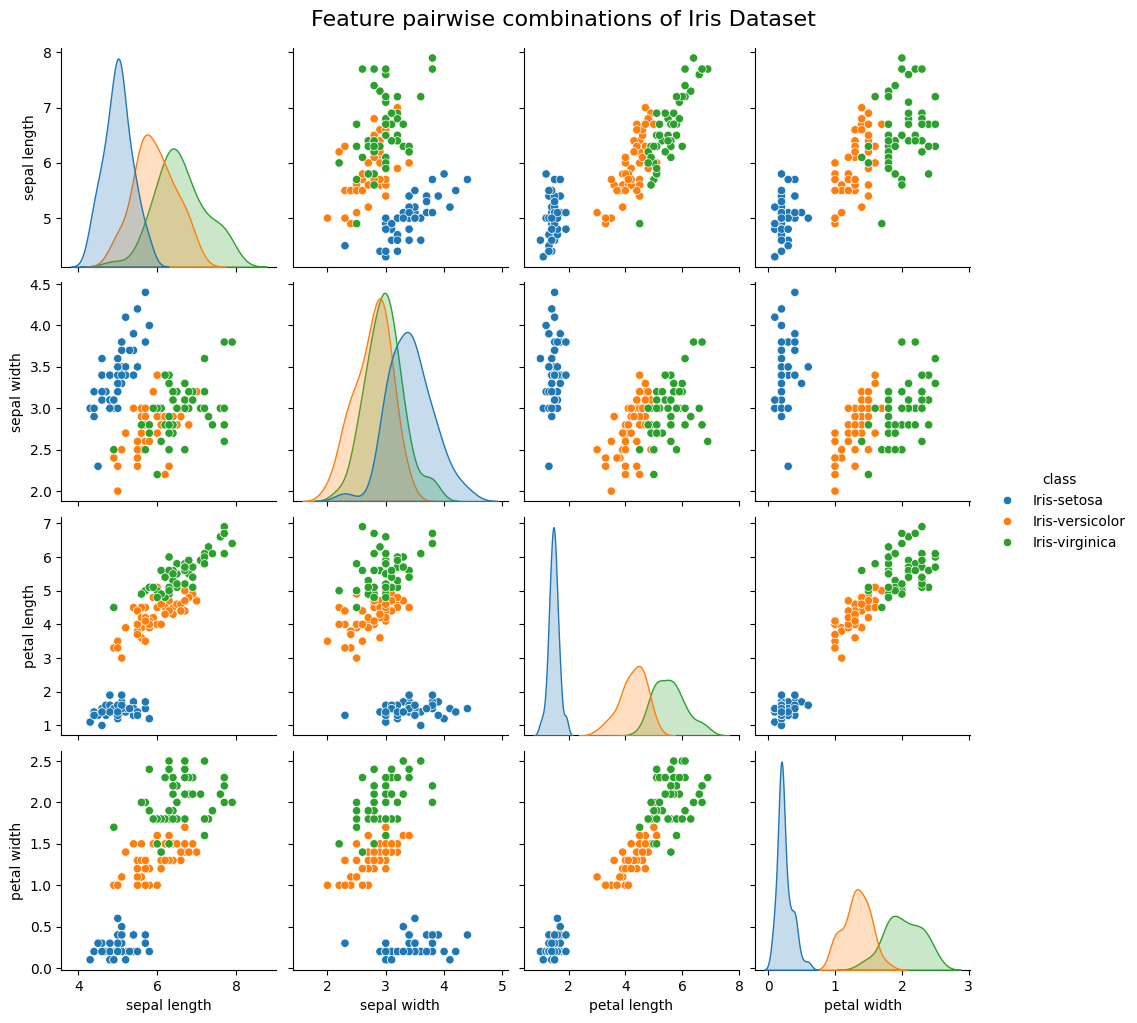

In [3]:
pairplot_iris = sns.pairplot(iris_df, hue = 'class')
pairplot_iris.fig.suptitle("Feature pairwise combinations of Iris Dataset", fontsize=16, y=1.02)
plt.savefig("pairwise_plot.png", bbox_inches='tight')
plt.show()

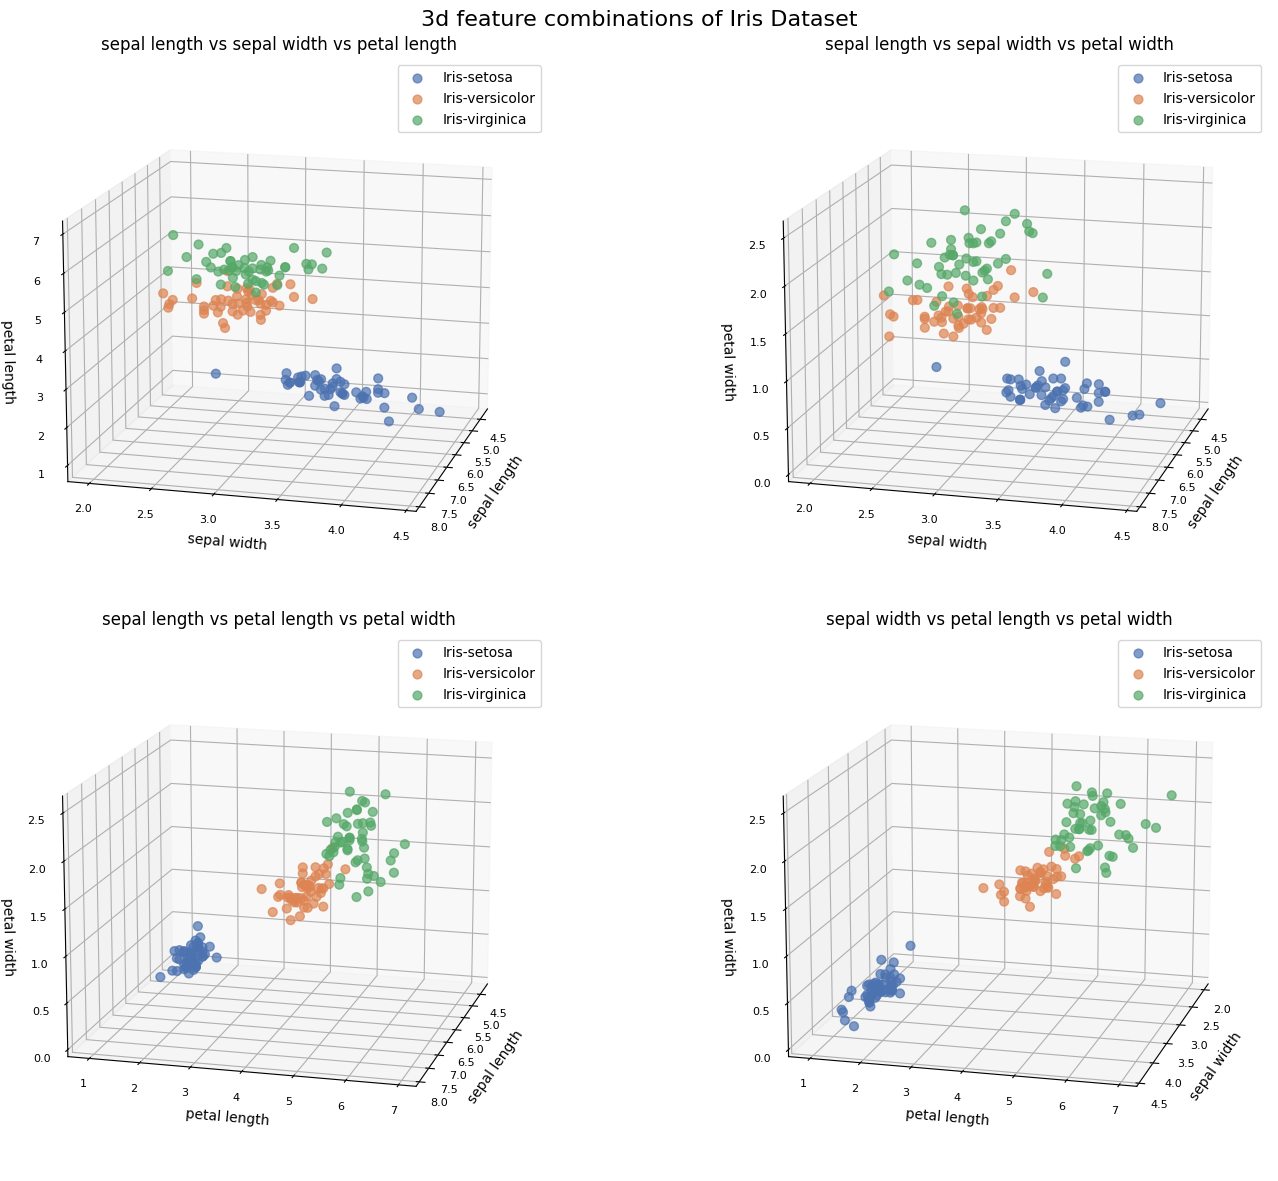

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations

# Get all unique combinations of 3 features (no axis swaps)
feature_combos = list(combinations(iris_df.columns[:-1], 3))
n_plots = len(feature_combos)

# Determine grid size (e.g., 2x2 for 4 plots)
n_cols = 2
n_rows = (n_plots + 1) // n_cols
classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
# Setup seaborn palette
palette = sns.color_palette("deep", 3)
species_to_color = dict(zip(classes, palette))

# Create 3D plots
fig = plt.figure(figsize=(8 * n_cols, 6 * n_rows))

for i, (x, y, z) in enumerate(feature_combos):
    ax = fig.add_subplot(n_rows, n_cols, i + 1, projection='3d')
    ax.view_init(elev=15, azim=15)
    for species in classes:
        sub_df = iris_df[iris_df['class'] == species]
        ax.scatter(sub_df[x], sub_df[y], sub_df[z],
                   label=species, color=species_to_color[species], s=40, alpha=0.7)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)    
    ax.set_title(f'{x} vs {y} vs {z}', fontsize=12)
    ax.tick_params(labelsize=8)

    if i == 0:
        ax.legend(fontsize=8)
        
    ax.legend()

fig.suptitle("3d feature combinations of Iris Dataset", fontsize=16)
plt.tight_layout()
plt.savefig("triplewise_plot.png", bbox_inches='tight')
plt.show()

The plots above allow us to infer the following.

 - The pairwise plot of the features indicates that with any two features the `Iris-setosa` can be clearly separated from the other two species.
 - The distribution plots show that the `Iris-versicolor` and `Iris-virginica` species have a better contrast for the `petal_width` and `petal_length` features. However, these features seem to be linearly correlated.
 - The distribution plot for `sepal_length` show moderated contrast between the three species. Indeed, the 3d plot `sepal_length` vs. `petal_length` vs. `petal_width` seems to show good separation between the species.

### 4.2 - The logistic regression model

 #### 4.2.1 - Model with `petal_length` and `petal_width`

In [5]:
X = np.array(iris.data.features[['petal length', 'petal width']])
y = np.array(iris.data.targets).flatten()

In [6]:
model = LogisticRegressor() #instance of the `LogisticRegressor class

In [7]:
model.fit(X, y)

In [8]:
y_hat = model.predict(X)

In [9]:
model.get_params()

{'intercept': array([82.23076724, 45.27234377,  0.        ]),
 'coef_1': array([-15.79886984,  -5.75453232,   0.        ]),
 'coef_2': array([-26.45490805, -10.44669989,   0.        ])}

In [10]:
model.classes_

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

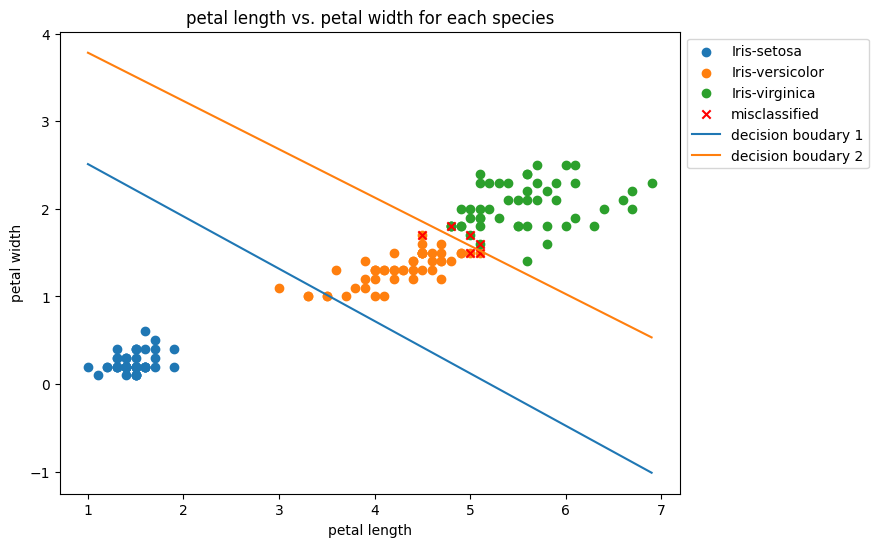

In [11]:
plt.figure(figsize = (8,6))
for species in classes:
    plt.scatter(X[np.where(y_hat == species), 0], X[np.where(y_hat == species), 1], label = species)

plt.scatter(X[np.where(y != y_hat), 0], X[np.where(y != y_hat), 1], marker = 'x', color = 'red', label = 'misclassified')
plt.plot(np.linspace(X[:, 0].min(), X[:, 0].max()), -(model.intercept_[0] + model.coef_[0, 0]*np.linspace(X[:, 0].min(), X[:, 0].max()))/model.coef_[1, 0], label = 'decision boudary 1')
plt.plot(np.linspace(X[:, 0].min(), X[:, 0].max()), -(model.intercept_[1] + model.coef_[0, 1]*np.linspace(X[:, 0].min(), X[:, 0].max()))/model.coef_[1, 1], label = 'decision boudary 2')
plt.title('petal length vs. petal width for each species')
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig("classification_2d.png", bbox_inches='tight')
plt.show()

In [12]:
model.confusion_matrix(X, y)

+----------------------+-----------------------+---------------------------+--------------------------+
|         ***          | predicted Iris-setosa | predicted Iris-versicolor | predicted Iris-virginica |
+----------------------+-----------------------+---------------------------+--------------------------+
|   true Iris-setosa   |          50.0         |            0.0            |           0.0            |
| true Iris-versicolor |          0.0          |            47.0           |           3.0            |
| true Iris-virginica  |          0.0          |            3.0            |           47.0           |
+----------------------+-----------------------+---------------------------+--------------------------+


In [13]:
model.scores(X, y)

+---------------------+-------------------+-----------------------+----------------------+-------------+
|       quantity      | class Iris-setosa | class Iris-versicolor | class Iris-virginica | all classes |
+---------------------+-------------------+-----------------------+----------------------+-------------+
|      prevalence     |       0.3333      |         0.3333        |        0.3333        |     ---     |
|      precision      |        1.0        |          0.94         |         0.94         |     ---     |
|        recall       |        1.0        |          0.94         |         0.94         |     ---     |
|  true positive rate |        1.0        |          0.94         |         0.94         |     ---     |
| false positive rate |        0.0        |          0.06         |         0.06         |     ---     |
|       accuracy      |        ---        |          ---          |         ---          |     0.96    |
+---------------------+-------------------+------------

In [14]:
model.regression_report(X, y)

+-----------+------------------------------+---------------------------+------------------------------+---------+
|   *****   |         coefficient          |         std. error        |         z-statistics         | p-value |
+-----------+------------------------------+---------------------------+------------------------------+---------+
| intercept |  [82.2308 45.2723  0.    ]   | [36.9121  1.1114  0.    ] |  [ 2.2277 40.735   0.    ]   |   0.0   |
|   coef_1  | [-15.7989  -5.7545   0.    ] | [32.8525  0.1883  0.    ] | [ -0.4809 -30.5642   0.    ] |   0.0   |
|   coef_2  | [-26.4549 -10.4467   0.    ] | [78.932   0.3066  0.    ] | [ -0.3352 -34.0674   0.    ] |   0.0   |
+-----------+------------------------------+---------------------------+------------------------------+---------+


 #### 4.2.2 - Model with `petal_length`, `petal_width` and `sepal_length`

In [15]:
X = np.array(iris.data.features[['petal length', 'petal width', 'sepal length']])
y = np.array(iris.data.targets).flatten()

In [16]:
model = LogisticRegressor() #instance of the `LogisticRegressor class

In [17]:
model.fit(X, y)

In [18]:
y_hat = model.predict(X)

In [19]:
model.get_params()

{'intercept': array([33.44449242, 40.83103357,  0.        ]),
 'coef_1': array([-22.56553188,  -9.75437443,   0.        ]),
 'coef_2': array([-23.81844354, -10.10155311,   0.        ]),
 'coef_3': array([13.47291088,  3.8386588 ,  0.        ])}

In [20]:
model.classes_

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

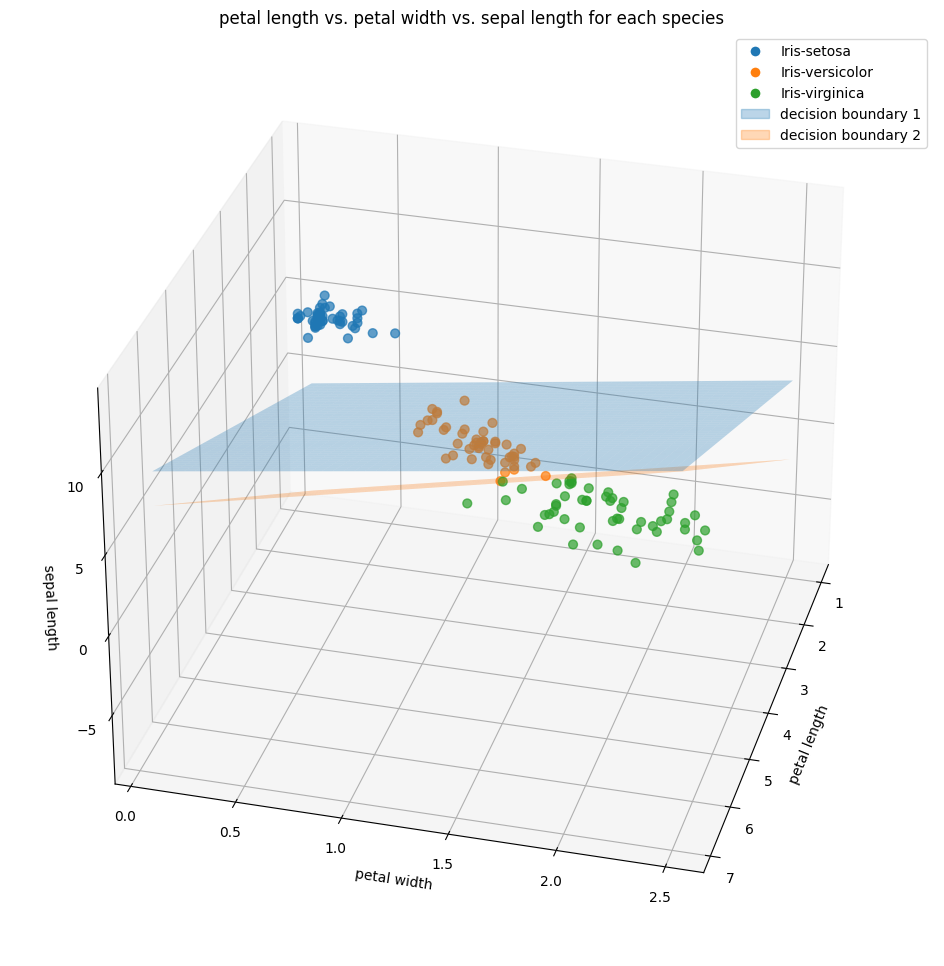

In [21]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Create figure
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=15)
for species in classes:
    ax.scatter(X[np.where(y_hat == species), 0], X[np.where(y_hat == species), 1], X[np.where(y_hat == species), 2], s=40, alpha=0.7, label = species)

# Create meshgrid over the x-y domain
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max()),
                     np.linspace(X[:, 1].min(), X[:, 1].max()))
ax.plot_surface(xx, yy, -(model.intercept_[0] + model.coef_[0, 0]*xx + model.coef_[1, 0]*yy)/model.coef_[2, 0], 
                alpha=0.3, color=default_colors[0], rstride=1, cstride=1, edgecolor='none')
ax.plot_surface(xx, yy, -(model.intercept_[1] + model.coef_[0, 1]*xx + model.coef_[1, 1]*yy)/model.coef_[2, 1], 
                alpha=0.3, color=default_colors[1], rstride=1, cstride=1, edgecolor='none')
ax.set_xlabel('petal length')
ax.set_ylabel('petal width')
ax.set_zlabel('sepal length')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=classes[0],
           markerfacecolor=default_colors[0], markersize=8),
    Line2D([0], [0], marker='o', color='w', label=classes[1],
           markerfacecolor=default_colors[1], markersize=8),
    Line2D([0], [0], marker='o', color='w', label=classes[2],
           markerfacecolor=default_colors[2], markersize=8),
    Patch(facecolor=default_colors[0], edgecolor=default_colors[0], label='decision boundary 1', alpha=0.3),
    Patch(facecolor=default_colors[1], edgecolor=default_colors[1], label='decision boundary 2', alpha=0.3)
]


ax.legend(handles = legend_elements)
plt.title('petal length vs. petal width vs. sepal length for each species')
plt.savefig("classification_3d.png", bbox_inches='tight')
plt.show()

In [22]:
model.confusion_matrix(X, y)

+----------------------+-----------------------+---------------------------+--------------------------+
|         ***          | predicted Iris-setosa | predicted Iris-versicolor | predicted Iris-virginica |
+----------------------+-----------------------+---------------------------+--------------------------+
|   true Iris-setosa   |          50.0         |            0.0            |           0.0            |
| true Iris-versicolor |          0.0          |            48.0           |           2.0            |
| true Iris-virginica  |          0.0          |            1.0            |           49.0           |
+----------------------+-----------------------+---------------------------+--------------------------+


In [23]:
model.scores(X, y)

+---------------------+-------------------+-----------------------+----------------------+-------------+
|       quantity      | class Iris-setosa | class Iris-versicolor | class Iris-virginica | all classes |
+---------------------+-------------------+-----------------------+----------------------+-------------+
|      prevalence     |       0.3333      |         0.3333        |        0.3333        |     ---     |
|      precision      |        1.0        |         0.9796        |        0.9608        |     ---     |
|        recall       |        1.0        |          0.96         |         0.98         |     ---     |
|  true positive rate |        1.0        |          0.96         |         0.98         |     ---     |
| false positive rate |        0.0        |          0.02         |         0.04         |     ---     |
|       accuracy      |        ---        |          ---          |         ---          |     0.98    |
+---------------------+-------------------+------------

In [24]:
model.regression_report(X, y)

+-----------+------------------------------+------------------------------+------------------------------+---------+
|   *****   |         coefficient          |          std. error          |         z-statistics         | p-value |
+-----------+------------------------------+------------------------------+------------------------------+---------+
| intercept |  [33.4445 40.831   0.    ]   | [260.6473   1.5145   0.    ] |  [ 0.1283 26.961   0.    ]   |   0.0   |
|   coef_1  | [-22.5655  -9.7544   0.    ] |  [38.2751  0.3646  0.    ]   | [ -0.5896 -26.7552   0.    ] |   0.0   |
|   coef_2  | [-23.8184 -10.1016   0.    ] |  [67.578   0.3761  0.    ]   | [ -0.3525 -26.8596   0.    ] |   0.0   |
|   coef_3  |  [13.4729  3.8387  0.    ]   |  [61.4973  0.1739  0.    ]   |  [ 0.2191 22.0739  0.    ]   |   0.0   |
+-----------+------------------------------+------------------------------+------------------------------+---------+
